In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile
from dsp import fm_demod
from utils import bandpass, lowpass, plot_signals, welch

# TODO
 1. Where do PLL harmonics come from? Use different filter?
 2. Do we use good cutoff frequencies?
 3. Why is there such a delay between RDS subcarrier signal and demodulated signal?
 4. Matched filtering before timing recovery.
 5. Why demodulated signal has this very low frequency present modulating it's amplitude?
    - would Costas loop do better?
 7. Complex downconversion of RDS signal? (it's BPSK tho, should be symmetrical - question is if M & M works properly)
 8. What about biphase coding?
 9. Error correction doesn't really work!
    - only error detection works
    - only improvement it gives is we don't reject some groups because they seem "fixed" but it completely messes up e.g. PI code, text data as well
 10. Block synchronization relies on adjacent blocks, would looking further behind speed up sync acquisition?
 11. Expose decoder output signals - lost sync, failed and successful error corrections, block types...

# Read and inspect the data

References: [PySDR](https://pysdr.org/content/rds.html)

Data source: [SDR play](https://www.sdrplay.com/iq-demo-files/)

In [2]:
sample_rate, samples = wavfile.read('data/rds/SDRuno_20200907_184033Z_88110kHz.wav')

/tmp/ipykernel_34356/2441168133.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read('data/rds/SDRuno_20200907_184033Z_88110kHz.wav')


In [3]:
print(f'Samples: {samples.shape[0]}\nSample rate: {sample_rate}\nDuration: {(samples.shape[0] / sample_rate)}s')

Samples: 10362880
Sample rate: 250000
Duration: 41.45152s


/home/jakub/projects/SDR/SDR/env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:454: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


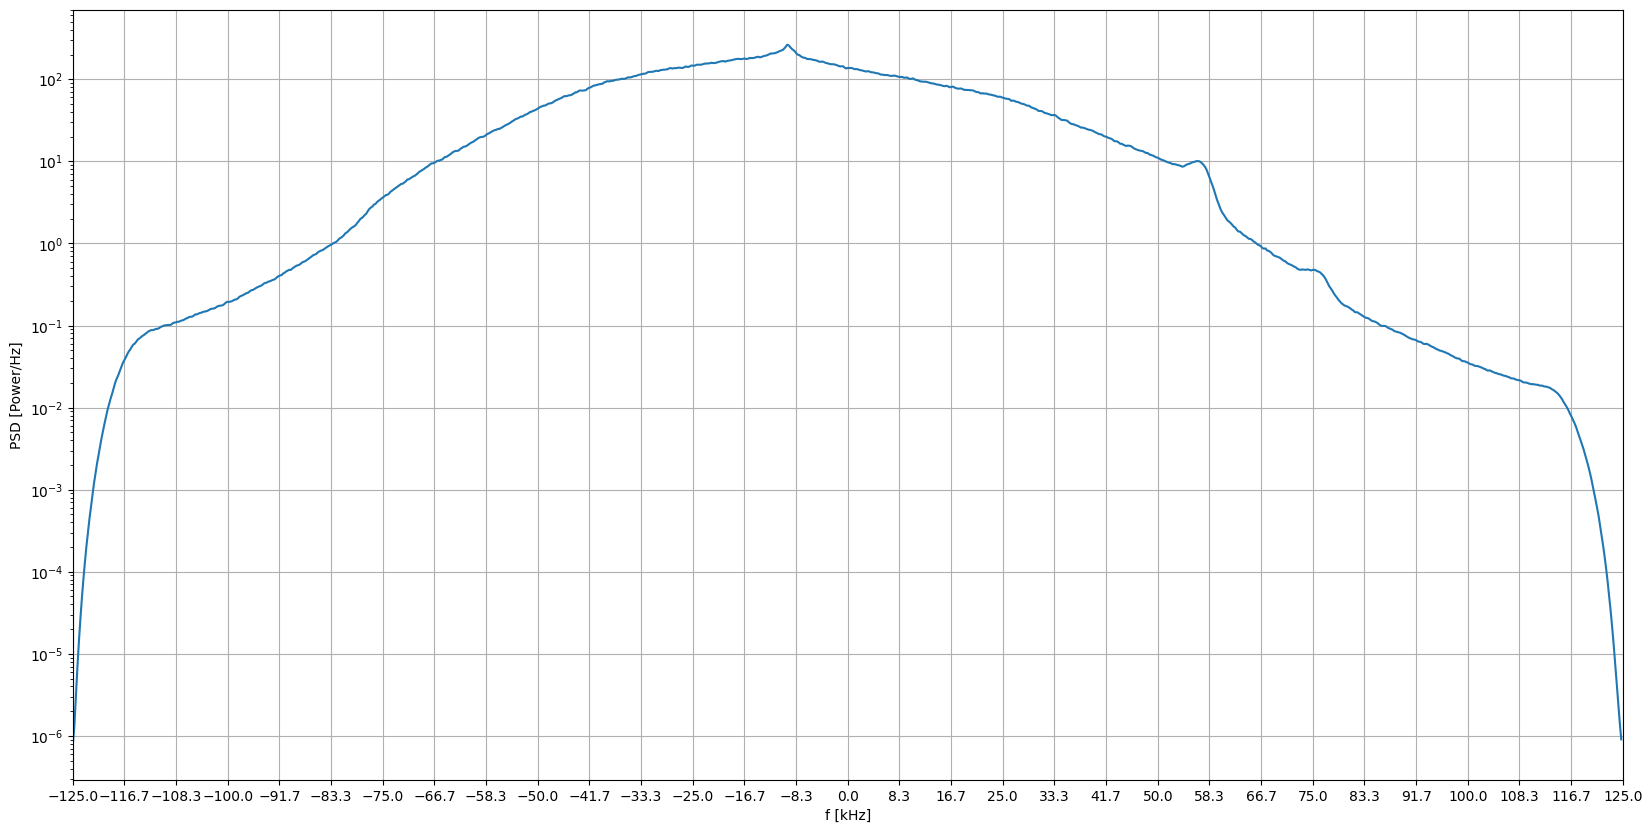

In [4]:
iq_samples = samples[:, 0] + 1j * samples[:, 1]
welch(iq_samples, sample_rate)

So we have an FM signal with about 250kHz bandwidth, downconverted to baseband.

# Demodulate FM signal

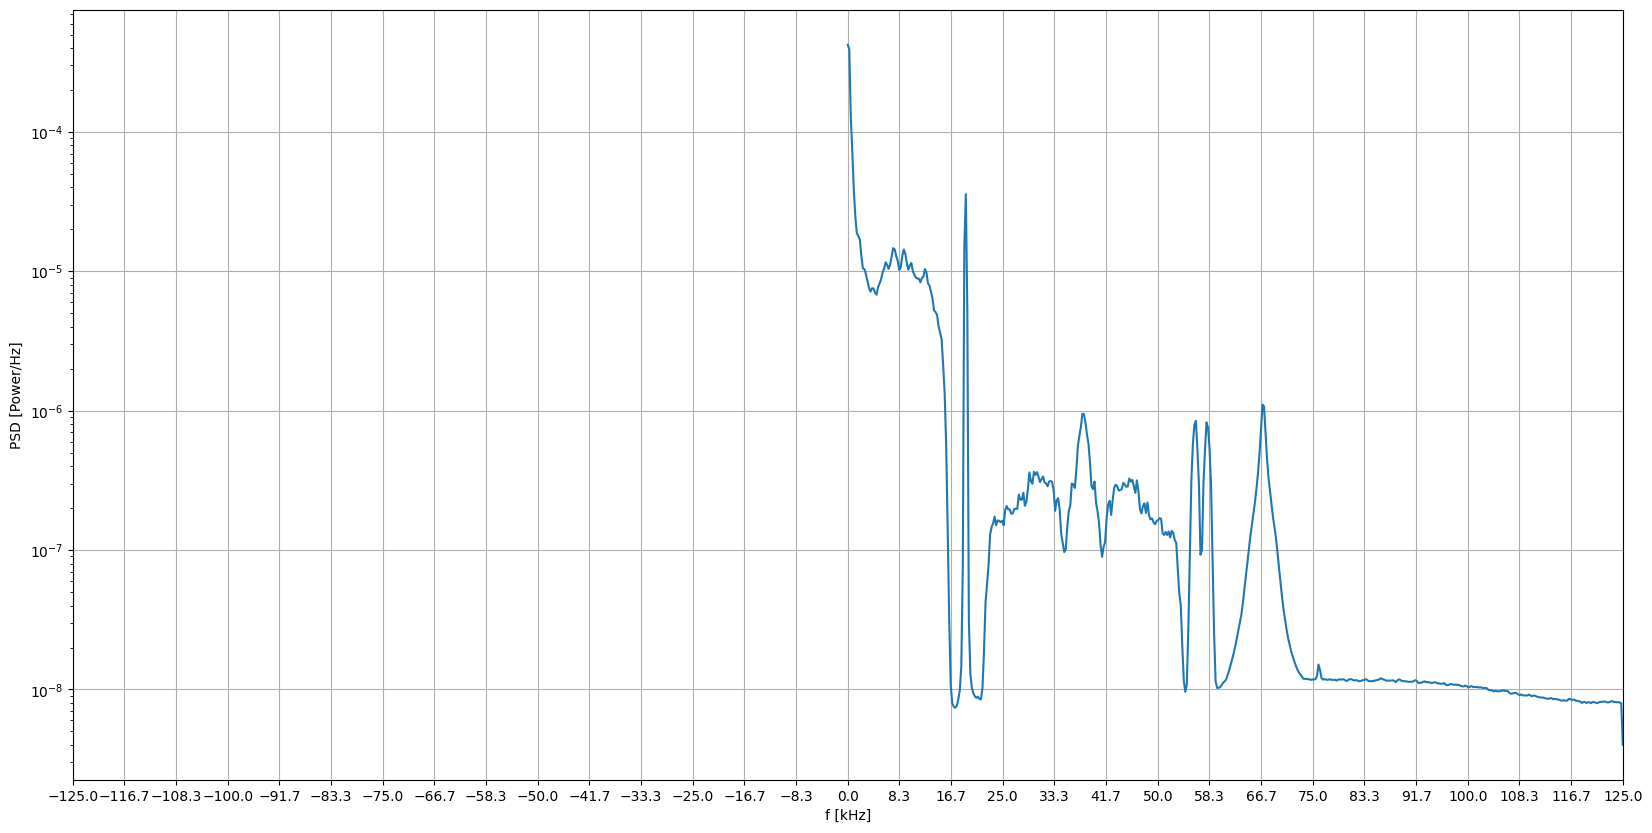

In [5]:
fm_modulating_signal = fm_demod(iq_samples)
welch(fm_modulating_signal, sample_rate)

Picture-perfect - we can clearly see:
 - audio band up to around 16kHz
 - strong pilot tone at 19kHz
 - string FM stereo signal at 38kHz
 - strong RDS BPSK signal at 57kHz
 - [DirectBand](https://en.wikipedia.org/wiki/DirectBand) signal at 67 kHz

# Lock onto pilot tone
Bandpass filter the pilot tone and use a phase-locked loop to get phase estimates. These can be later used to demodulate 57kHz RDS signal since it should be locked in-phase to the pilot. We use +/- 2.4kHz for filtering of the pilot

In [6]:
def calc_loop_params(damping_factor, noise_bandwidth, sample_rate, ped_gain=0.5, nco_gain=1):
    k_p = (4 * damping_factor * noise_bandwidth) / (ped_gain * nco_gain * (damping_factor + 1 / (4 * damping_factor)) * sample_rate)
    k_i = (4 * noise_bandwidth ** 2) / (ped_gain * nco_gain * ((damping_factor + 1 / (4 * damping_factor)) * sample_rate) ** 2)
    return k_p, k_i

k_p, k_i = calc_loop_params(damping_factor=1 / np.sqrt(2),noise_bandwidth=0.05 * sample_rate, sample_rate=sample_rate)
k_p, k_i

(0.26666666666666666, 0.01777777777777778)

In [7]:
def pll(input_signal, sample_rate, base_frequency, k_p, k_i, nco_gain):
    phases, errors = np.zeros(len(input_signal)), np.zeros(len(input_signal))
    integrator_acc, phase = 0, 0
    
    for i, sample in enumerate(input_signal):
        # cos here means phases will be for use in sin function
        error = np.cos(2 * np.pi * base_frequency * i / sample_rate + phase) * sample
        
        integrator_acc += (k_i * error)
        phase += (nco_gain * (integrator_acc + k_p * error))

        phases[i] = phase
        errors[i] = error
        
    return phases, errors

In [8]:
pilot_frequency_hz = 19000
pilot_bandwidth_hz = 2400
pilot_signal = bandpass(fm_modulating_signal, sample_rate, pilot_frequency_hz - pilot_bandwidth_hz / 2, pilot_frequency_hz + pilot_bandwidth_hz / 2, N=6)

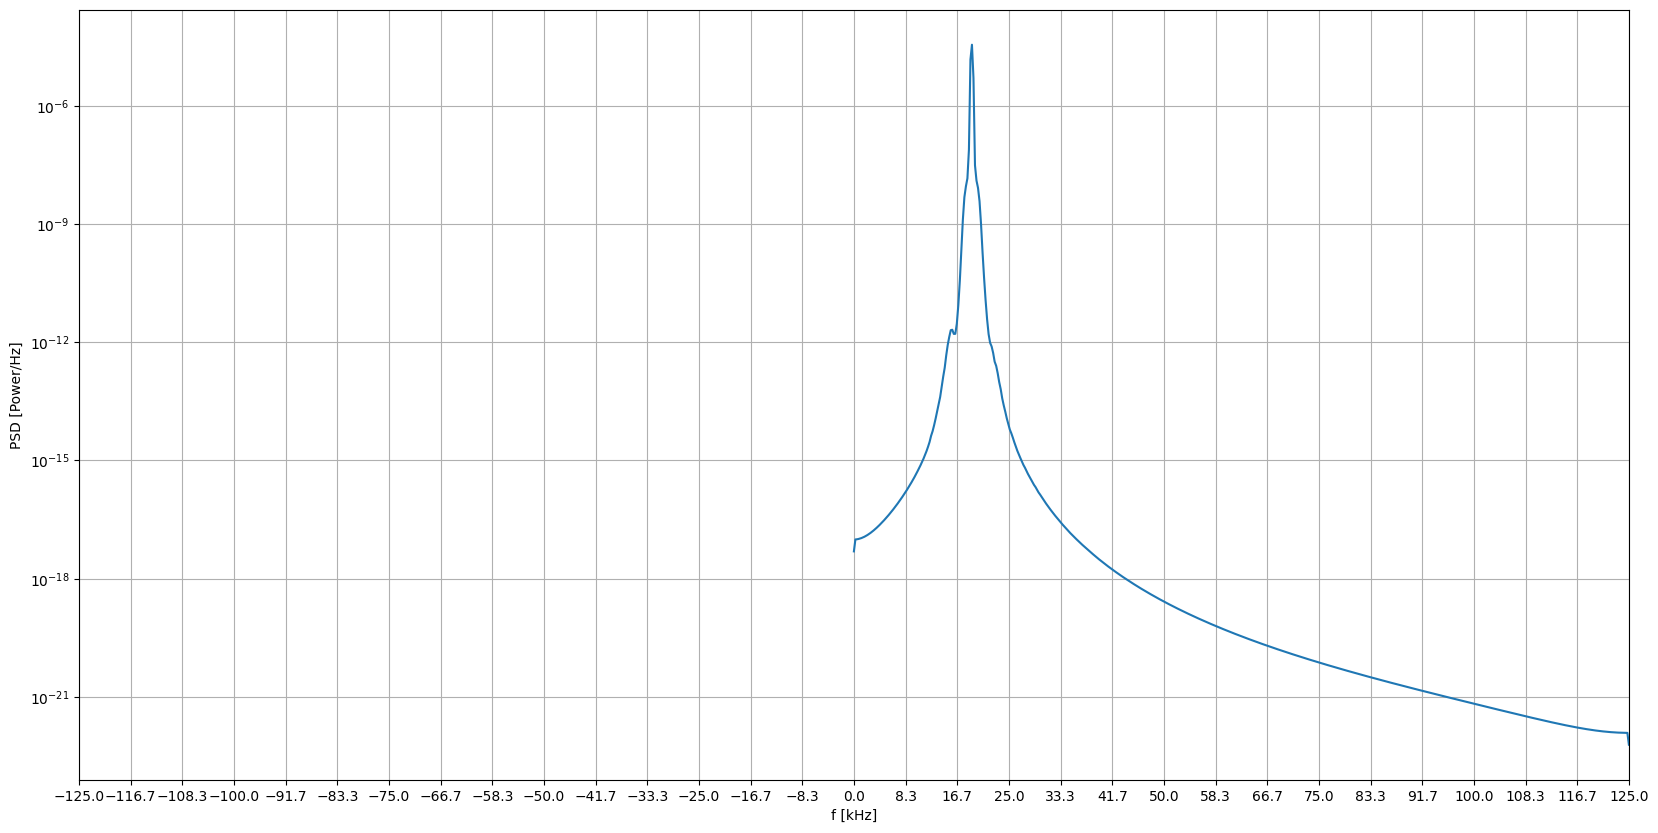

In [9]:
welch(pilot_signal, sample_rate)

Interestingly, number of Butterworth filter coefficients cannot be much higher because apparently numeric overflows occur during filtering. 6 seems like a balance between cutoff quality and complexity.

In [10]:
phases, errors = pll(pilot_signal, sample_rate, pilot_frequency_hz, k_p, k_i, 1)

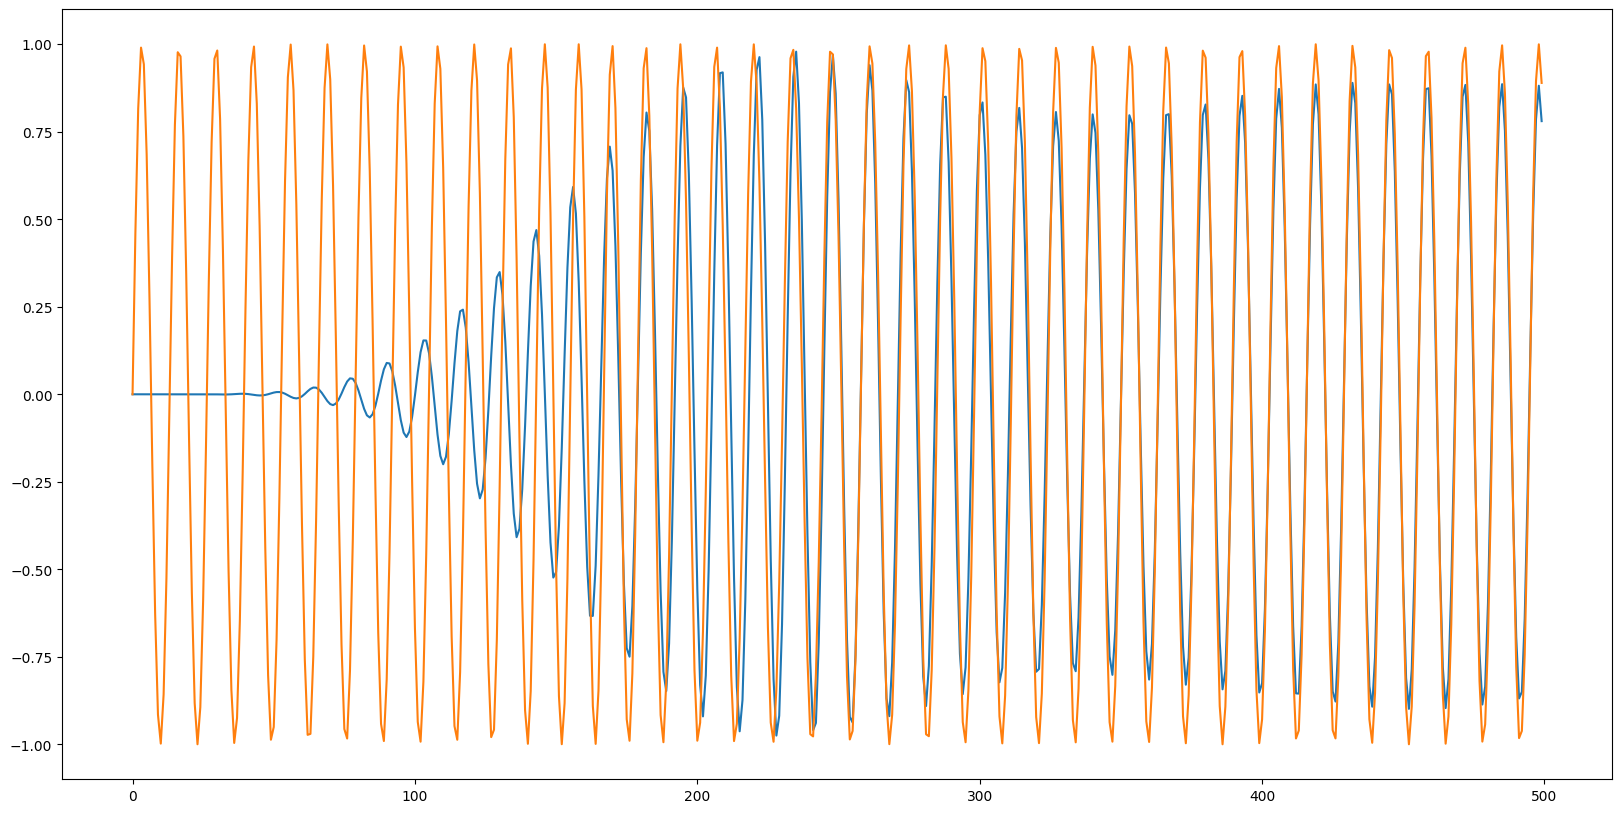

In [11]:
t_s = np.arange(0, len(pilot_signal) / sample_rate, 1 / sample_rate)[:len(phases)]
recovered_pilot_signal = np.sin(2 * np.pi * pilot_frequency_hz * t_s + phases)
plot_signals([pilot_signal, recovered_pilot_signal], start=0, width=500)

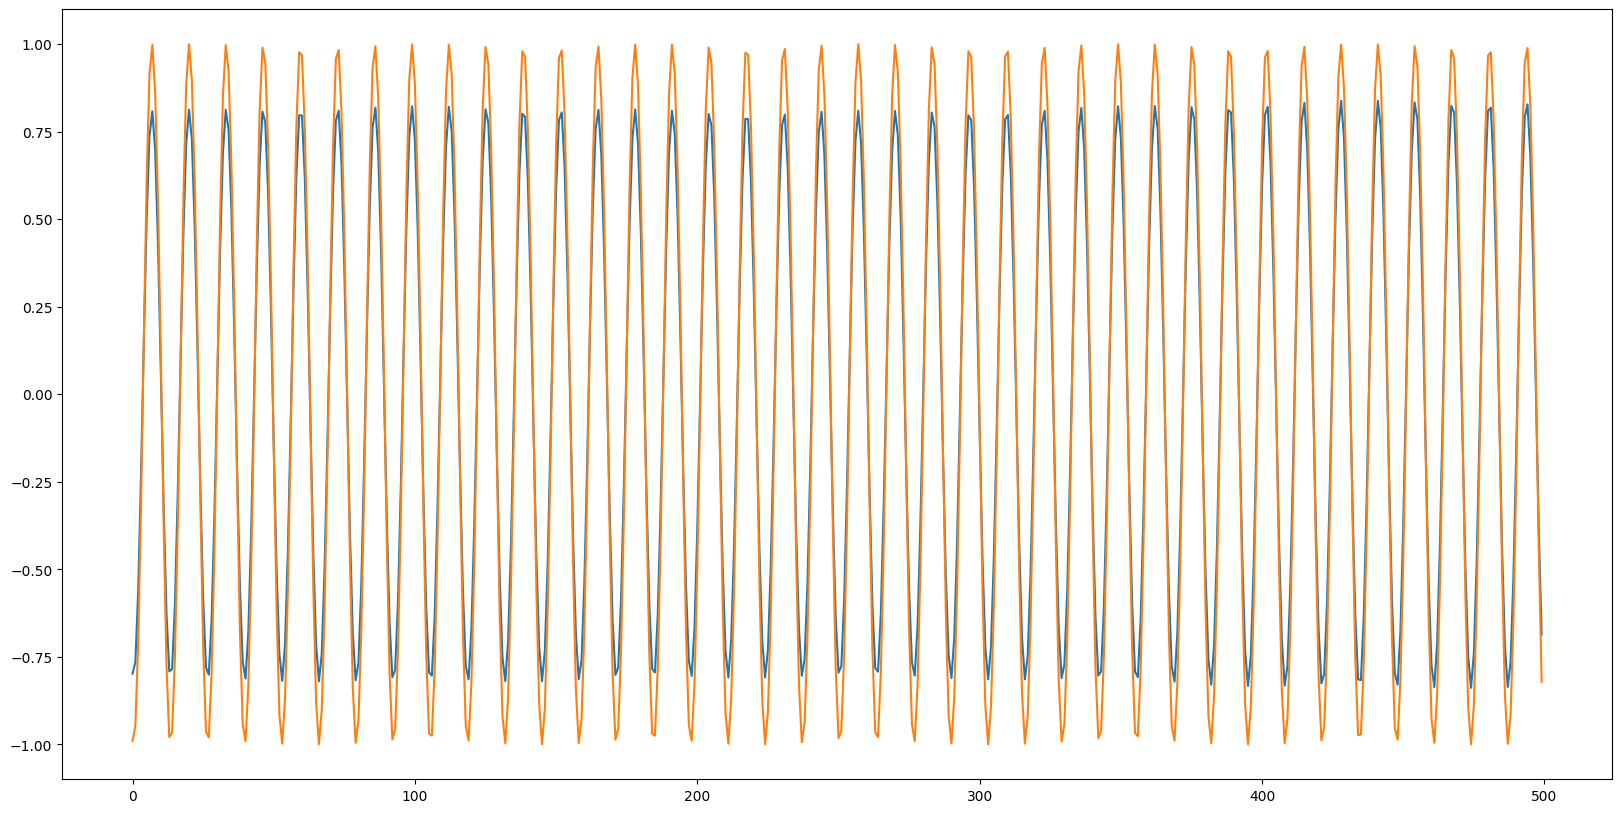

In [12]:
plot_signals([pilot_signal, recovered_pilot_signal], start=200_000, width=500)

Hopefully we have achieved sync. Let's take a look at spectrum of recovered pilot signal.

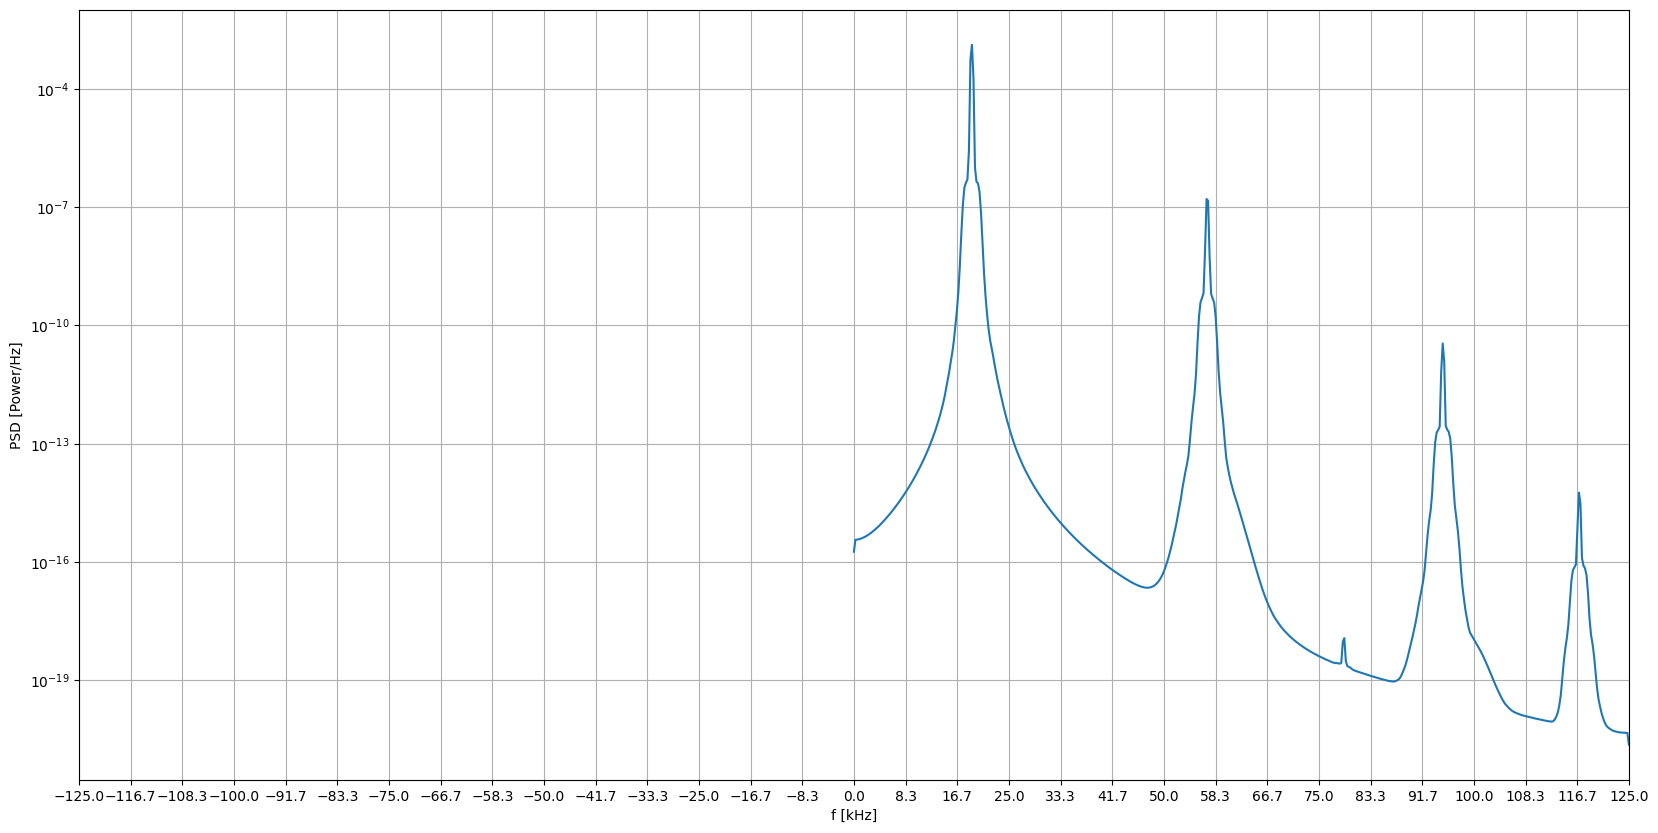

In [13]:
welch(recovered_pilot_signal, sample_rate)

Very interesting. We get multiple harmonics of the pilot tone. It's probably because of the harmonics in phase signal - perhaps PLL filter should be adjusted?

These harmonics are also present in our recovered RDS subcarrier (after multiplying phase by 3), so **we'll need to bandpass filter it before modulation**!

# Demodulate BPSK signal at 57kHz subcarrier
Bandpass filter the RDS signal and use 3x our phase estimates for pilot to demodulate the BPSK signal.

In [14]:
rds_frequency_hz = 57000
rds_bandwidth_hz = 4800
rds_signal = bandpass(fm_modulating_signal, sample_rate, rds_frequency_hz - rds_bandwidth_hz / 2, rds_frequency_hz + rds_bandwidth_hz / 2, N=8)

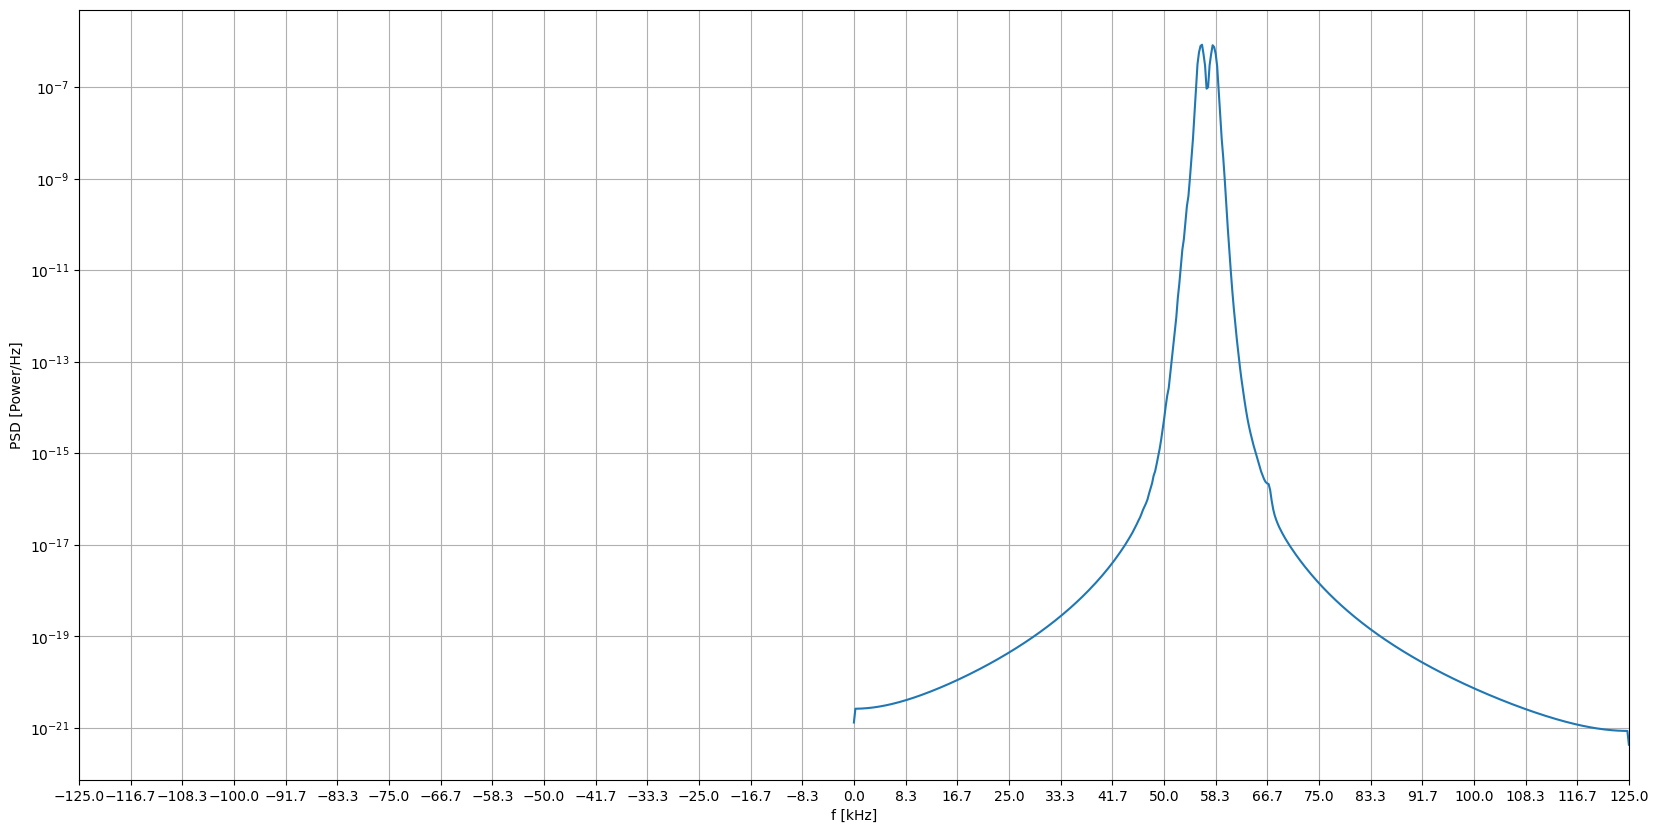

In [15]:
welch(rds_signal, sample_rate)

In [16]:
recovered_rds_subcarrier = np.sin(3 * (2 * np.pi * pilot_frequency_hz * t_s + phases))
recovered_rds_subcarrier_no_harmonics = bandpass(
    recovered_rds_subcarrier, sample_rate, rds_frequency_hz - rds_bandwidth_hz / 2, rds_frequency_hz + rds_bandwidth_hz / 2, N=8
)
rds_signal_shifted = rds_signal * recovered_rds_subcarrier_no_harmonics
rds_signal_demodulated = lowpass(rds_signal_shifted, sample_rate, 4800)

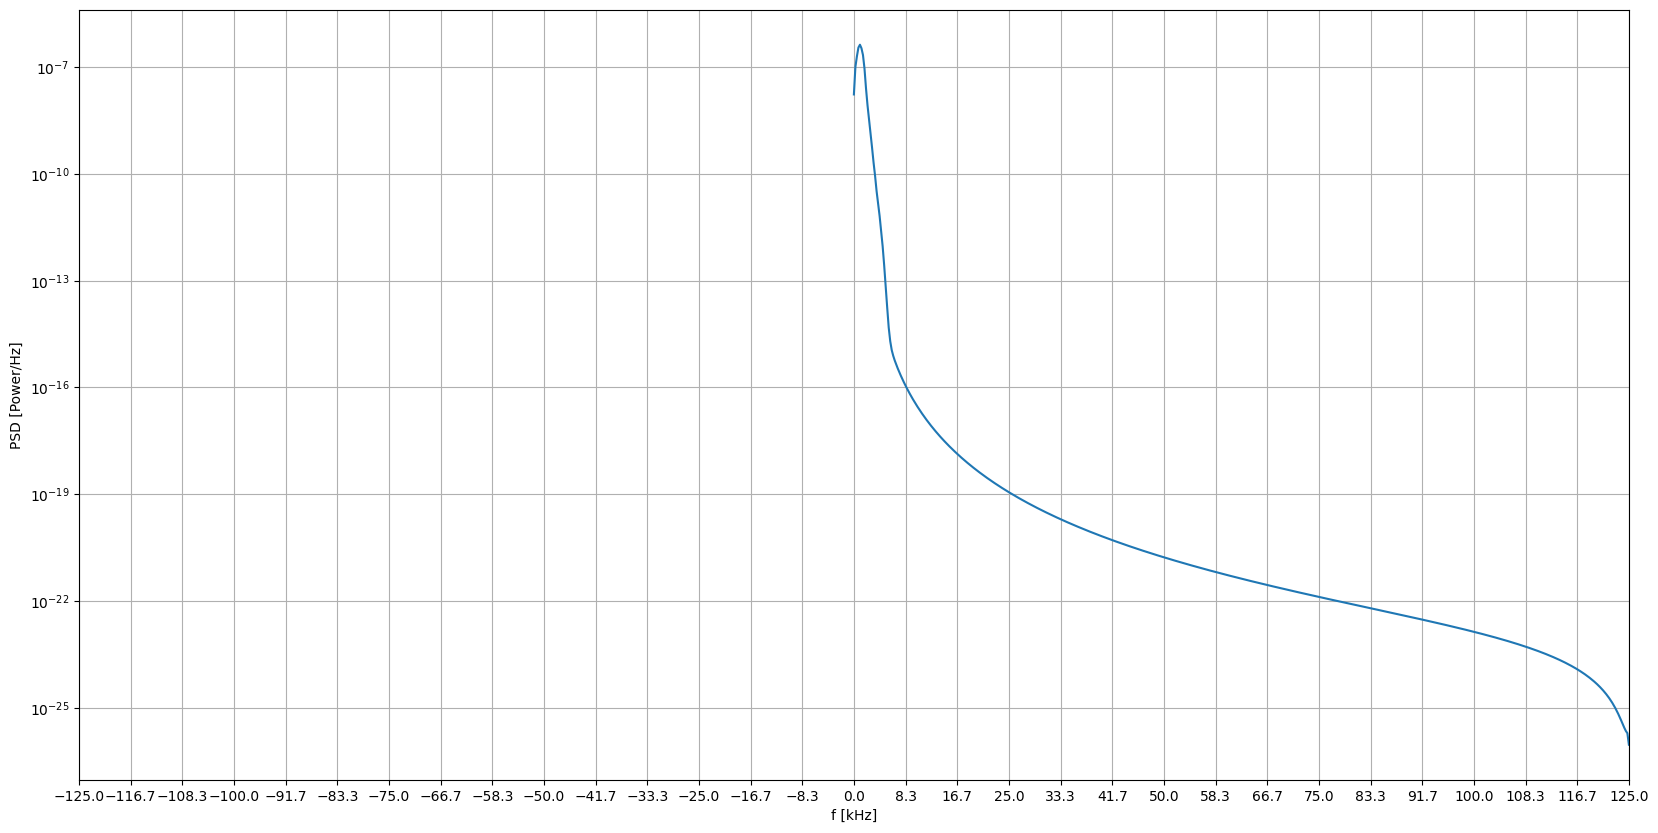

In [17]:
welch(rds_signal_demodulated, sample_rate)

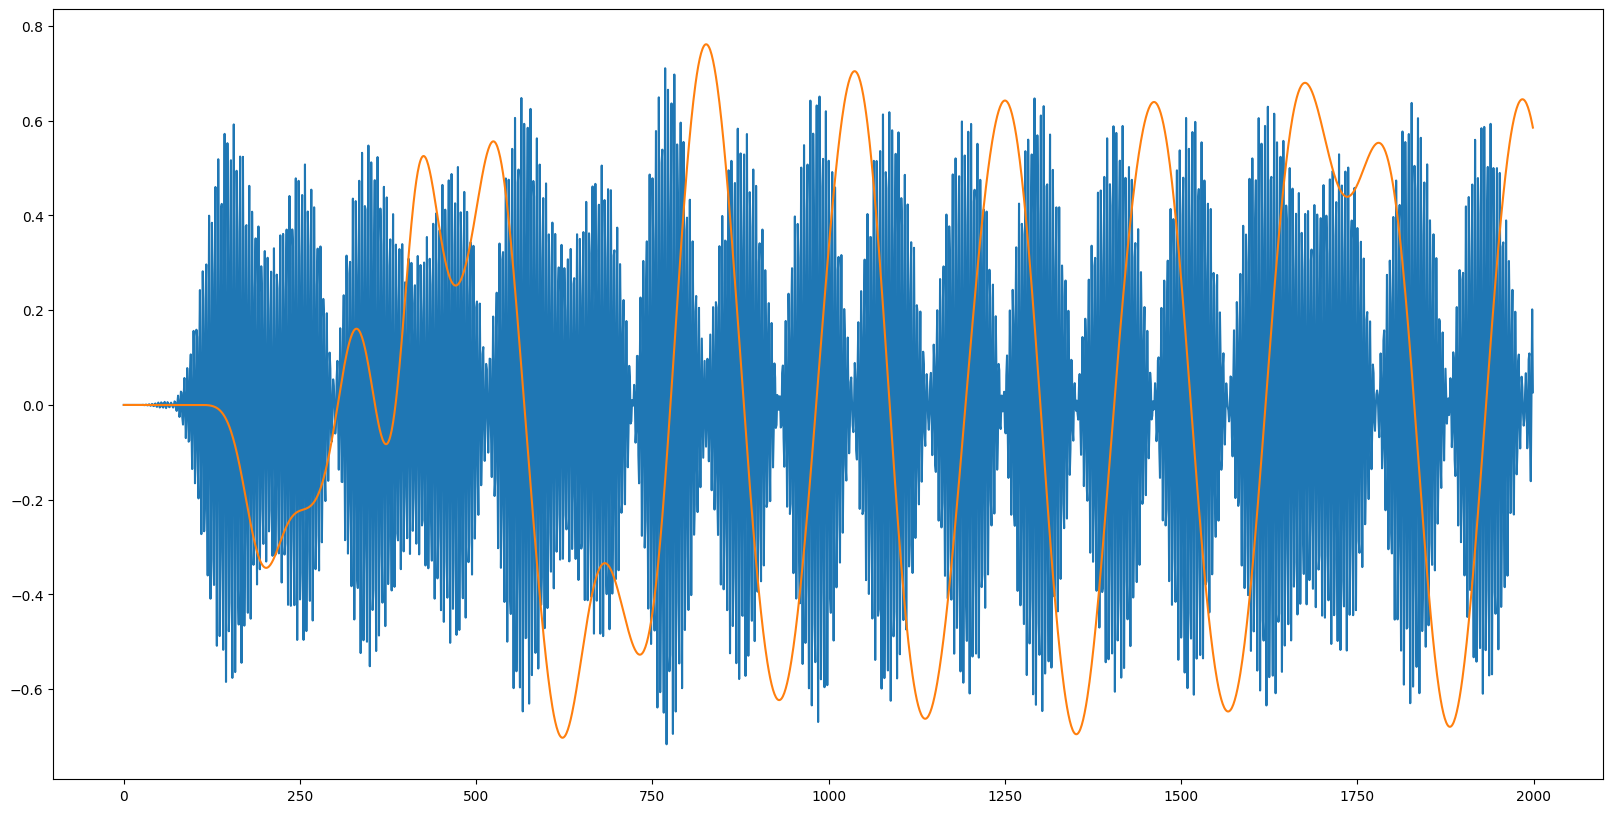

In [18]:
plot_signals([rds_signal, rds_signal_demodulated], start=0, width=2000)

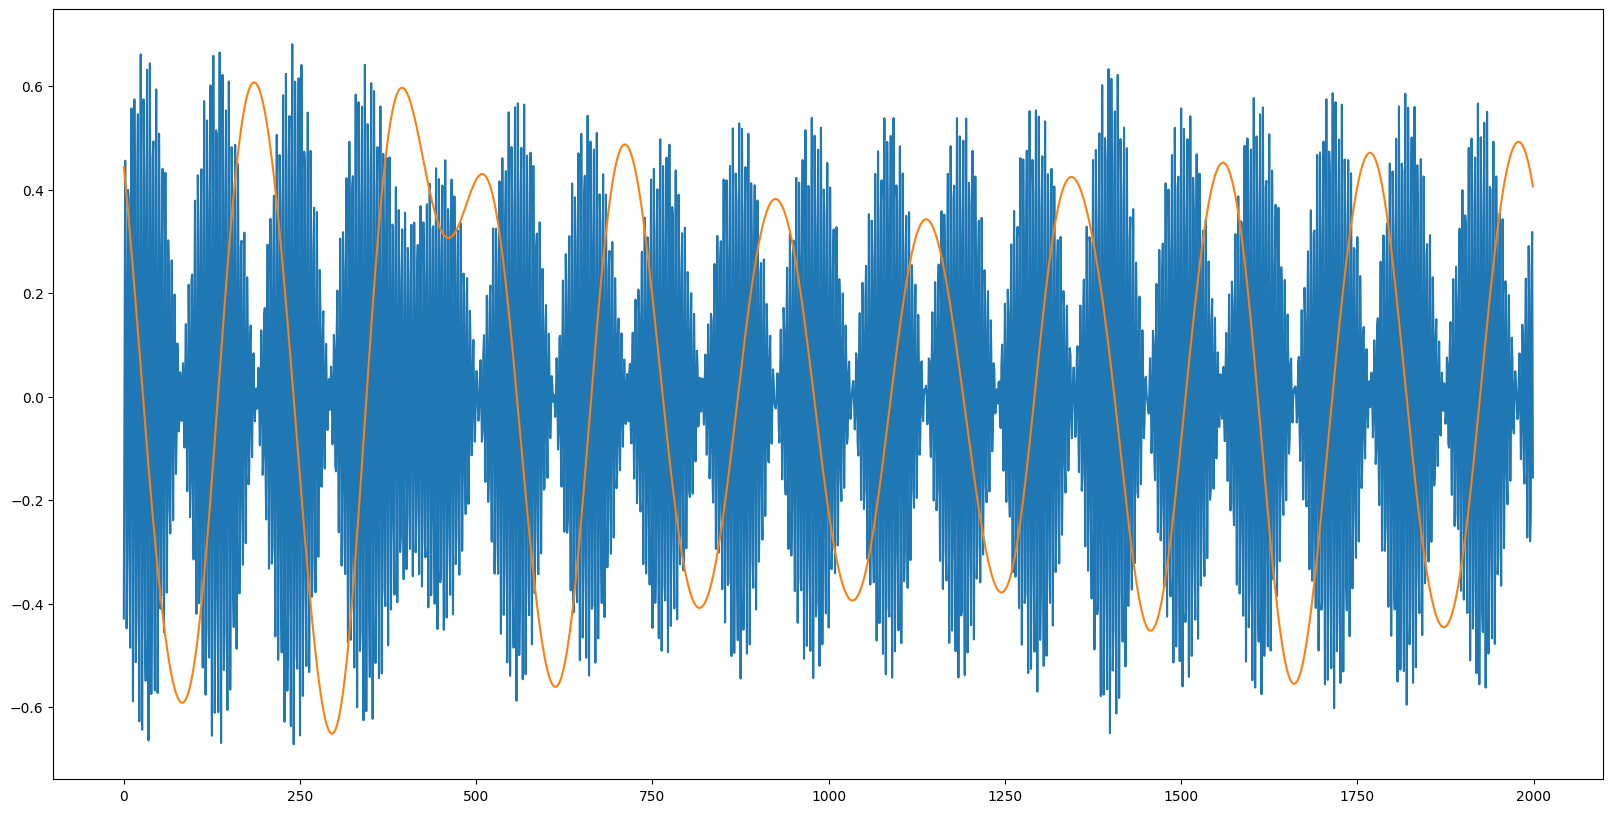

In [19]:
plot_signals([rds_signal, rds_signal_demodulated], start=500000, width=2000)

Very interesting as usual! Demodulated signal follows original (good) but there's a substantial delay (not great but it shouldn't affect data we recover from the signal).

# Timing recovery to get BPSK constellation symbols
Use Mueller & Muller method.

In [20]:
def mm_sync_bpsk(signal, sample_rate, symbol_rate, alpha=0.3):
    samples_per_symbol = sample_rate / symbol_rate
    
    def bpsk_symbol(sample):
        return 2 * int(np.real(sample) > 0) - 1 + 1j * 0

    deltas = []
    sample_indexes = [0]
    i = int(samples_per_symbol)
    delta_t = 0
    
    while i < len(signal):
        sample_indexes.append(i)
        deltas.append(delta_t)
        
        sample_1, sample_2 = signal[sample_indexes[-1]], signal[sample_indexes[-2]]
        symbol_1, symbol_2 = bpsk_symbol(sample_1), bpsk_symbol(sample_2)
        
        mm_delta = np.real(sample_2 * np.conj(symbol_1) - sample_1 * np.conj(symbol_2))
        delta_t += samples_per_symbol + alpha * mm_delta
        
        i += int(delta_t)
        delta_t -= int(delta_t)
    
    return np.array(sample_indexes), np.array(deltas)

In [21]:
symbol_rate = 1187.5
sample_indexes, deltas = mm_sync_bpsk(rds_signal_demodulated, sample_rate, symbol_rate)

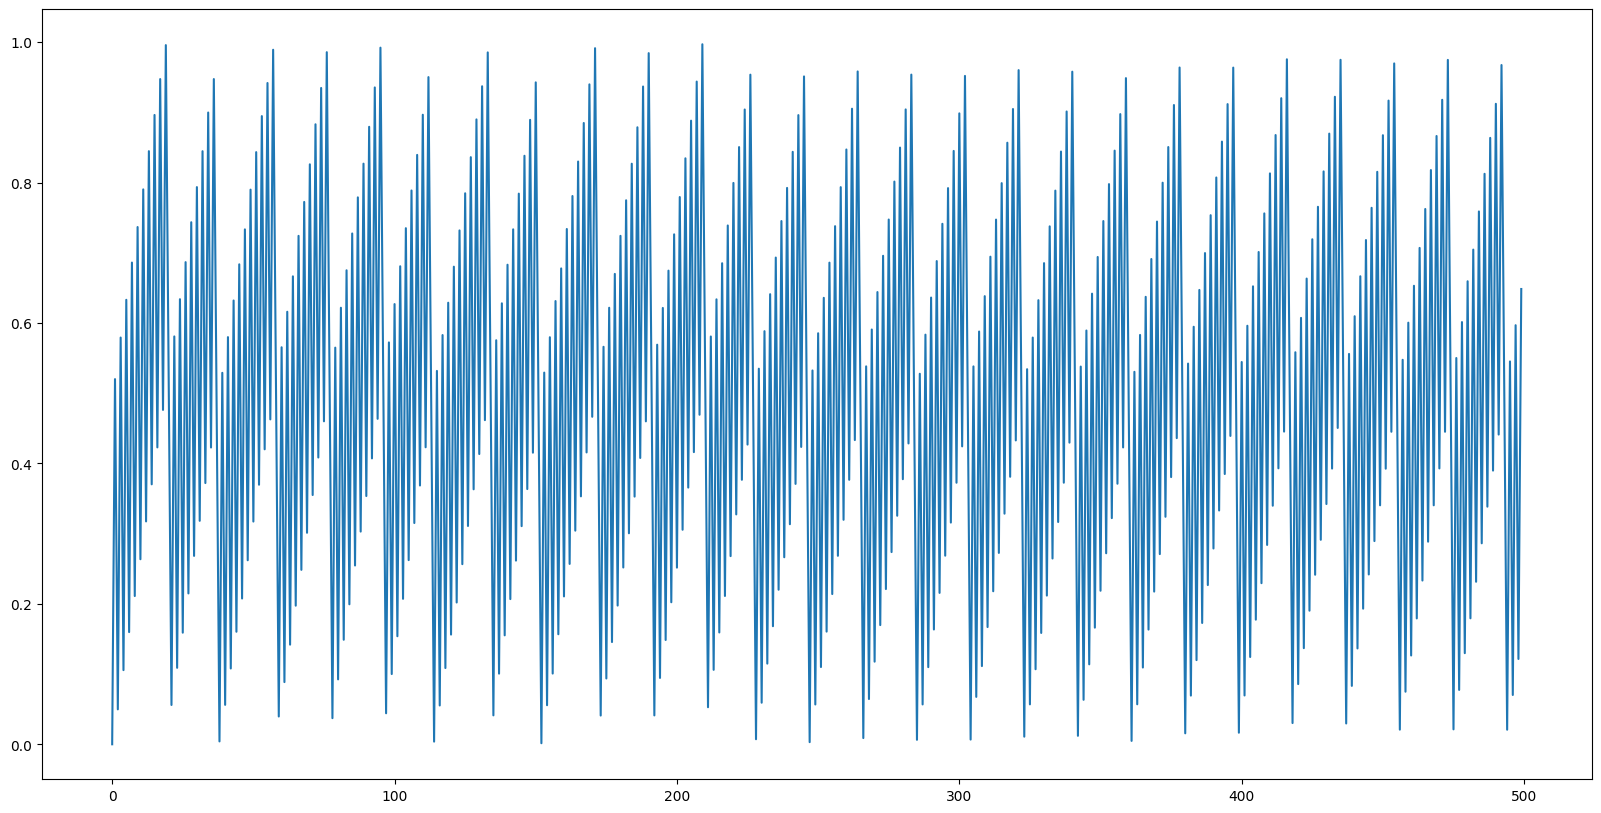

In [22]:
plot_signals([deltas], start=0, width=500)

In [23]:
def plot_signal_with_highlighted(signal, selected_indexes, start=0, width=None):
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 5))
    
    ax.plot(signal[start:start + width])
    
    selected_indexes = [idx for idx in sample_indexes if start <= idx <= start + width]
    ax.plot([idx - start for idx in selected_indexes], [signal[idx] for idx in selected_indexes], '*');

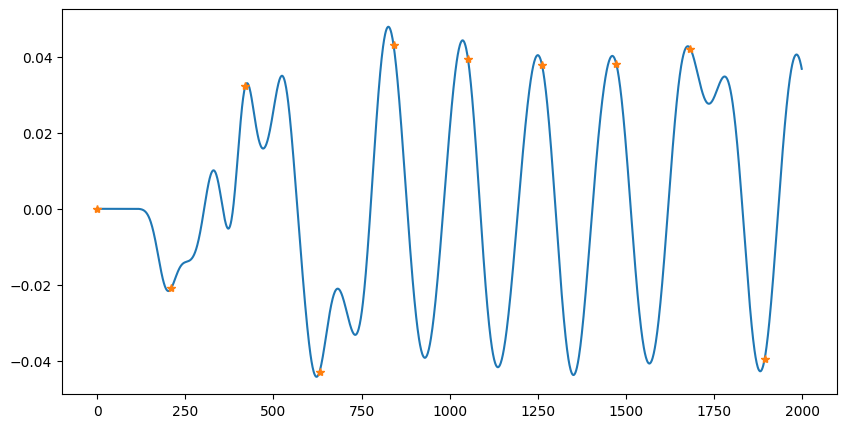

In [24]:
plot_signal_with_highlighted(rds_signal_demodulated, sample_indexes, start=0, width=2000)

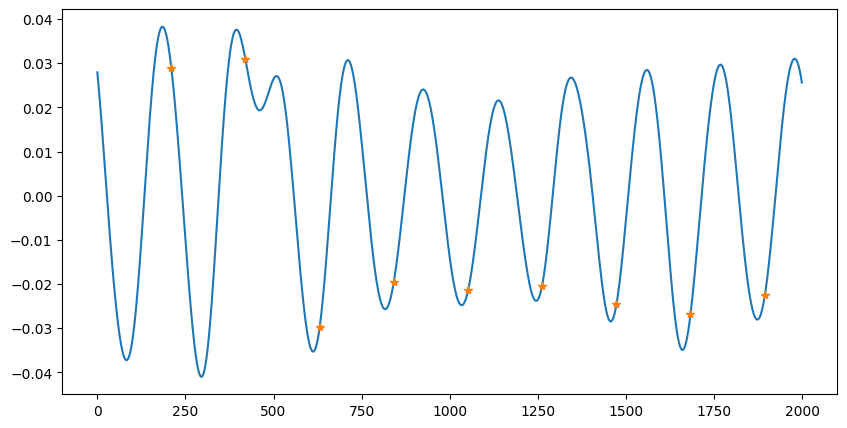

In [25]:
plot_signal_with_highlighted(rds_signal_demodulated, sample_indexes, start=500000, width=2000)

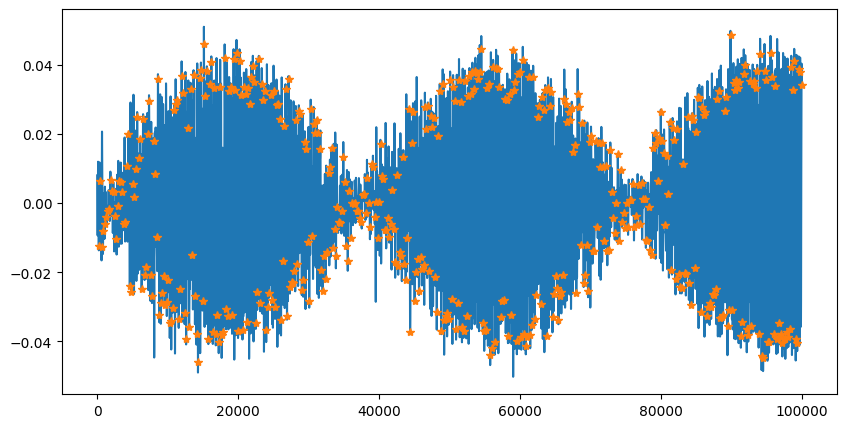

In [26]:
plot_signal_with_highlighted(rds_signal_demodulated, sample_indexes, start=20000, width=100000)

Another mistery - why does the amplitude of demodulated signal vary like that? Looks like it's amplitude is modulated by very low frequency sinusoid with half-period around 38000 samples - perhaps locking onto pilot tone didn't really do the job? Or maybe this FM station doesn't keep the pilot in sync with RDS subcarrier?

We'll see if that's a problem with decoding the data.

In [27]:
print(f'Frequency of modulating sinusoid is around {1 / (2 * 38000 / sample_rate)}Hz.')

Frequency of modulating sinusoid is around 3.2894736842105265Hz.


# BPSK constellation symbols to bits and differential decoding

In [28]:
symbols = rds_signal_demodulated[sample_indexes]
diff_encoded_bits = np.array([int(symbol > 0) for symbol in symbols])

In [29]:
data_bits = np.abs(diff_encoded_bits[1:] - diff_encoded_bits[:-1])

In [30]:
n_bits = data_bits.shape[0]
n_blocks = n_bits // 26
n_groups = n_blocks // 4
print(f'{n_bits} bits of data\n{n_blocks} blocks of data\n{n_groups} groups')

49223 bits of data
1893 blocks of data
473 groups


# Error correction and block synchronization
Source: EN50067 3.1.

1. We can decode block A without sync - it's always Programme Identification code (PI)
2. We can decode block B's Traffic Programme code (TP) on bit 6  without sync
3. We can decode block B's Programme Type code (PTY) on bits 7-11 without sync
4. If the 5th bit of block B $B_0 = 1$ (type B group), then block 3 is equal to block 1 (PI code)
    1. it's also indicated by the usage of offset word C' in block 3
5. For everything else, when in sync:
    1.  we consider block B's bits 1-6 to find the group type
    2.  we decode data from block C and D accordinly
6. Synchronization mechanism is described in EN50067 Annex C. 

For now we're just interested in decoding RadioText data, because it's the most spectacular. Other interesting group types:
 - 0A - alternative frequencies
 - 0B - programme service name segment

### RadioText decoding
Source: EN50067 3.1.5.3.

 1. Type A groups carry 4 bytes of text data in C and D blocks, type B - 2 bytes only in D blocks.
 2. Characters are encoded according to EN50067 Annex E. **Luckily**, at least Latin letter codes seem to match ASCII codes, so we don't have to implement the lookup table.
 3. Bits 13-16 of block B indicate address of group's text data in the whole message (type A groups can transfer messages up to 64 characters long).
 4. Bit 12 of block B is called text A/B flag. When it's value changes, previously received RadioText data should be cleaned from memory and message should be formed from scratch.

In [31]:
from dataclasses import dataclass
from typing import Optional
from rds_coding import block_syndrome, correct_block, syndrome_block_type, block_type_offset_word

In [32]:
@dataclass
class Group:
    pi: int
    block_2: Optional[int] = None
    block_3: Optional[int] = None
    block_4: Optional[int] = None
    complete: bool = False


def block_to_int(block):
    # 16 bits block
    block = np.packbits(block)
    return (block[0] << 8) | block[1]


def next_block_type(prev_block_tpe, prev_block_idx, next_block_idx):
    # unify C and Cp
    if prev_block_tpe == 'Cp':
        prev_block_tpe = 'C'

    types = ['A', 'B', 'C', 'D']
    prev_tpe_position = types.index(prev_block_tpe)
    next_tpe_position = (prev_tpe_position + (next_block_idx - prev_block_idx) // 26) % 4
    return types[next_tpe_position]

In [33]:
def corrected_block_with_type(block, expected_block_tpe):
    if expected_block_tpe == 'C':
        # it means C or Cp actually
        corrected_block = correct_block(block, block_type_offset_word('C'))
        if corrected_block is None:
            corrected_block = correct_block(block, block_type_offset_word('Cp'))
            return corrected_block, 'Cp'
        else:
            return corrected_block, 'C'
    else:
        corrected_block = correct_block(block, block_type_offset_word(expected_block_tpe))
        return corrected_block, expected_block_tpe

In [65]:
in_sync = False
prev_correct_block_idx = None
prev_correct_block_tpe = None

blocks_cnt = 0
error_blocks_cnt = 0
groups = []

error_correction_enabled = False


for i in range(0, len(data_bits) - 25):
    syndrome = block_syndrome(data_bits[i:i + 26])
    block_tpe = syndrome_block_type(syndrome)

    if not in_sync:
        # for now we only use two adjacent blocks for synchronization
        if block_tpe is not None:
            if prev_correct_block_idx is not None and i - prev_correct_block_idx == 26:
                expected_block_tpe = next_block_type(prev_correct_block_tpe, prev_correct_block_idx, i)
                if block_tpe == expected_block_tpe:
                    in_sync = True
                    print(f'Acquired sync at bit {i}.')

            prev_correct_block_idx = i
            prev_correct_block_tpe = block_tpe

    if in_sync:
        if (i - prev_correct_block_idx) % 26 == 0:
            # condition handles case of obtaining sync in this iteration (diff == 0) and in previous iterations
            block_correct = False
            blocks_cnt += 1

            expected_block_tpe = next_block_type(prev_correct_block_tpe, prev_correct_block_idx, i)

            if block_tpe is not None:
                # no error correction required
                block = data_bits[i:i + 16]
                block_correct = block_tpe == expected_block_tpe
            elif error_correction_enabled:
                # error correction can be attempted using expected offset word
                corrected_block, block_tpe = corrected_block_with_type(data_bits[i:i + 26], expected_block_tpe)
                if corrected_block is not None:
                    block = corrected_block
                    block_correct = True
            
            if not block_correct:
                error_blocks_cnt += 1
                if groups:
                    groups[-1].complete = True   

            # handle synchronization loss
            if blocks_cnt == 50:
                if error_blocks_cnt > 25:
                    in_sync = False
                    block_correct = False  # don't decode if lost sync
                    print(f'Lost sync at bit {i}: {error_blocks_cnt} errors in last {blocks_cnt} blocks.')
                blocks_cnt = error_blocks_cnt = 0

            if block_correct:
                prev_correct_block_idx = i
                prev_correct_block_tpe = block_tpe

                if block_tpe == 'A':
                    groups.append(Group(pi=block_to_int(block)))
                elif groups and not groups[-1].complete:
                    current_group = groups[-1]
                    if block_tpe == 'B':
                        current_group.block_2 = block_to_int(block)
                    elif block_tpe in ('C', 'Cp'):
                        current_group.block_3 = block_to_int(block)
                    else:
                        current_group.block_4 = block_to_int(block)
                        current_group.complete = True

Acquired sync at bit 35.
Lost sync at bit 14309: 31 errors in last 50 blocks.
Acquired sync at bit 14413.
Lost sync at bit 15687: 33 errors in last 50 blocks.
Acquired sync at bit 18754.
Lost sync at bit 20028: 32 errors in last 50 blocks.
Acquired sync at bit 20132.


In [66]:
len(groups)

303

In [69]:
def decode_group_type(block_2):
    return (block_2 >> 11) & 0x1f  # get 5 first bits


def decode_radiotext_index(block_2):
    return block_2 & 0xf


def decode_radiotext_ab(block_2):
    return (block_2 >> 4) & 0x01


def block_to_str(block):
    return chr((block >> 8) & 0xff) + chr(block & 0xff)


radiotext = [" "] * 64
radiotext_ab_flag = 0

for i, group in enumerate(groups):
    if group.block_2 is not None:
        group_tpe = decode_group_type(group.block_2)
        if group_tpe == 4:
            # RadioText groups 0A type (4 characters in group)
            idx = decode_radiotext_index(group.block_2)

            if group.block_3 is not None:
                str_3 = block_to_str(group.block_3)
                radiotext[4 * idx] = str_3[0]
                radiotext[4 * idx + 1] = str_3[1]
            if group.block_4 is not None:
                str_4 = block_to_str(group.block_4)
                radiotext[4 * idx + 2] = str_4[0]
                radiotext[4 * idx + 3] = str_4[1]

            print(''.join([c for c in radiotext if c != '\r']))  # because Jupyter sucks
            
            flag = decode_radiotext_ab(group.block_2)
            if radiotext_ab_flag != flag:
                radiotext = [" "] * 64
                radiotext_ab_flag = flag
                print('-' * 64)

                 Upb                                            
                 Upb                                            
                 Upb        l.                                 
Wa               Upb        l.                                 
Wa      lift     Upb        l.                                 
Wa      liftin   Upb        l.                                 
Wa      liftin   Upbeat.    l.                                 
Wa      liftin   Upbeat. R  l.                                 
Wa  M   liftin   Upbeat. R  l.                                 
Wa  M   liftin   Upbeat. R  l.                                 
Wa  M   liftin   Upbeat. R  l.                                 
Wa  M   liftin   Upbeat. R  l.                                 
Wa  M   liftin   Upbeat. R  l.                                 
Wa  M   liftin   Upbeat. R  l.                                 
Wa  M   liftin   Upbeat. R  l.                                 
Wa  M   liftin   Upbeat. Real.        

Well, it's something. Error correction for sure introduces errors (lol), without it data is clean - just some missing characters.